In [3]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
with ZipFile('dogs-vs-cats-redux-kernels-edition.zip') as zip_ref:
    zip_ref.extractall('ref_zip')
with ZipFile('ref_zip/train.zip') as zip_ref:
    zip_ref.extractall()

In [5]:
filenames = os.listdir('train')
labels = ['dog' if 'dog' in name else 'cat' for name in filenames]
df = pd.DataFrame({'filename' : filenames, 'label' : labels})
print(df.head())

        filename label
0   cat.9920.jpg   cat
1  cat.11403.jpg   cat
2   cat.2180.jpg   cat
3   cat.1109.jpg   cat
4    dog.696.jpg   dog


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2026-01-19 21:47:35.738026: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 21:47:36.547449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-19 21:47:38.828996: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/yongjun-kim/tf-torch/lib/python3.12/site-packages/keras/src/ex

In [7]:
igen = ImageDataGenerator(
    rescale = 1./255,        #사이즈 재정립
    validation_split = 0.2, #테스트 비율 나누기
    shear_range = 0.2,      #기울기
    zoom_range = 0.2,       #확대비율
    horizontal_flip = True  #좌우반전
)
train_gen = igen.flow_from_dataframe(
    df,
    directory = 'train',
    x_col = 'filename',
    y_col = 'label',
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training',
    seed = 42
)
val_gen = igen.flow_from_dataframe(
    df,
    directory = 'train',
    x_col = 'filename',
    y_col = 'label',
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'validation',
    seed = 42
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [8]:
#lenet-5 // 58%, cnn // 95%, SGD // 70% (왠만하면 아담, 정확도 높이고 싶으면 한번쯤 쓰기)
#배치 빼고 0.2 // 88.7, 배치 넣고 0,2 // 52%
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

In [9]:
cnn = Sequential()
cnn.add(Conv2D(32,(3,3), input_shape = (128,128,3)))#극소 패턴 추출
cnn.add(BatchNormalization())#출력을 정규화, 경사 폭주를 막음
cnn.add(Activation('relu'))
cnn.add(Conv2D(32,(3,3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))#맵 사이즈를 줄여 패턴찾기
cnn.add(Dropout(0.2))#과적합 방지

cnn.add(Conv2D(64,(3,3)))
#cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Conv2D(64,(3,3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(128,(3,3)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(128,(3,3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(256,(3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))

cnn.add(GlobalAveragePooling2D())#체널별 평균을 이용해 파라미터 감소
cnn.add(Dense(units = 128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(units = 1, activation = 'sigmoid'))
cnn.summary()

/home/yongjun-kim/tf-torch/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1768826861.368383    2551 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 615,841 (2.35 MB)

 Trainable params: 615,521 (2.35 MB)

 Non-trainable params: 320 (1.25 KB)

In [10]:
cnn.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [11]:
hist = cnn.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 30,
    callbacks = [early_stop, reduce_lr]
)

Epoch 1/30


2026-01-19 21:47:45.672191: I external/local_xla/xla/service/service.cc:163] XLA service 0x705030004220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-19 21:47:45.672225: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-19 21:47:45.753282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-19 21:47:46.300410: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-19 21:47:46.634201: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-19 21:47:46.

  2/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5469 - loss: 1.3787   

I0000 00:00:1768826876.653961    3110 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 96ms/step - accuracy: 0.5511 - loss: 0.6945 - val_accuracy: 0.6022 - val_loss: 0.6670 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.6033 - loss: 0.6644 - val_accuracy: 0.6276 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.6740 - loss: 0.6127 - val_accuracy: 0.6926 - val_loss: 0.5817 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.7064 - loss: 0.5765 - val_accuracy: 0.6286 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.7398 - loss: 0.5396 - val_accuracy: 0.5986 - val_loss: 0.8250 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.7492 - loss: 0.5183 - val_accuracy: 0.7558 - val_loss: 0.5029 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.7748 - loss: 0.4875

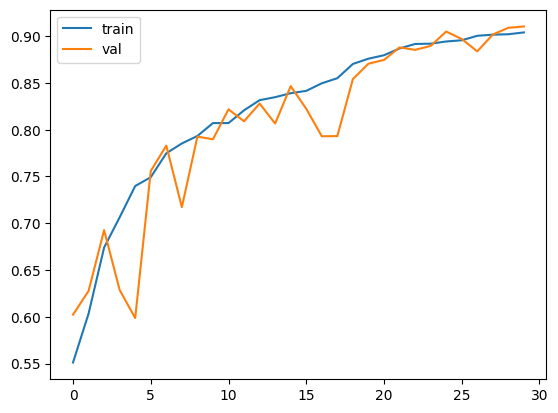

In [12]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

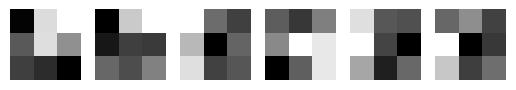

In [13]:
filters, biases = cnn.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
n_filters = 6
for i in range(n_filters):
    f = filters[:, :, :, i]
    plt.subplot(1,n_filters, i+1)
    plt.imshow(f[:,:,0], cmap = 'gray')
    plt.axis('off')
plt.show

In [14]:
cnn.save("ans.h5")

In [15]:
with ZipFile('/home/yongjun-kim/kaggle/cat_dog/ref_zip/test.zip') as zip_ref:
    zip_ref.extractall()

In [16]:
filenames = os.listdir('test')
df = pd.DataFrame({'filename' : filenames, 'label' : None})
df

,filename,label
0,10248.jpg,None
1,11744.jpg,None
2,3095.jpg,None
3,8833.jpg,None
4,4476.jpg,None
...,...,...
12495,1075.jpg,None
12496,2560.jpg,None
12497,171.jpg,None
12498,8546.jpg,None


In [17]:
test_datagen = ImageDataGenerator(rescale= 1./255)
test1_idg =  test_datagen.flow_from_dataframe(
                                    df, 
                                     "test", 
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = 32,
                                     target_size=(128,128),
                                     class_mode = None, 
                                     shuffle = False
                                     )
test1_idg

Found 12500 validated image filenames.


In [18]:
test1_predict = cnn.predict(test1_idg,verbose = 0)
test1_predict


2026-01-19 22:17:10.707144: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


array([[0.42574936],
       [0.09590205],
       [0.99532604],
       ...,
       [0.3876256 ],
       [0.0751357 ],
       [0.78059804]], shape=(12500, 1), dtype=float32)

In [19]:
y_test_pred = (test1_predict > 0.5).astype(int).flatten()
df['label'] = y_test_pred
df.head()

,filename,label
0,10248.jpg,0
1,11744.jpg,0
2,3095.jpg,1
3,8833.jpg,0
4,4476.jpg,1


In [20]:
df['id'] = df['filename'].str.split('.').str[0]
df.drop(['filename'], axis = 1)

,label,id
0,0,10248
1,0,11744
2,1,3095
3,0,8833
4,1,4476
...,...,...
12495,1,1075
12496,1,2560
12497,0,171
12498,0,8546


In [21]:
df = df[['id','label']]
df.to_csv('ans.csv', index=False)